# Petri Dish Analysis with YOLO

This notebook uses a hybrid approach:
1.  **Hough Transform** to find small, 6mm medicine disks.
2.  **Pixel-to-MM Calibration** using the known 6mm disk size.
3.  **YOLO Model** (pre-trained) to detect the large inhibition zones.
4.  **Measurement** of the final zone radius in millimeters (mm).

### Cell 1: Setup and Imports

This cell installs `ultralytics` for YOLO and imports all other necessary libraries.

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def display_images(images, titles):
    """
    Helper function to display multiple images side-by-side in a Jupyter Notebook.
    """
    plt.figure(figsize=(15, 7))
    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 3:
            image_to_show = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_to_show = image
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image_to_show, cmap='gray' if len(image_to_show.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')
    plt.show()

print("Libraries imported and helper function defined.")

Libraries imported and helper function defined.


### Cell 2: Load and Pre-process Image

Loads the original image and creates the `img_blurred` version for disk detection.

Image loaded and pre-processed successfully.


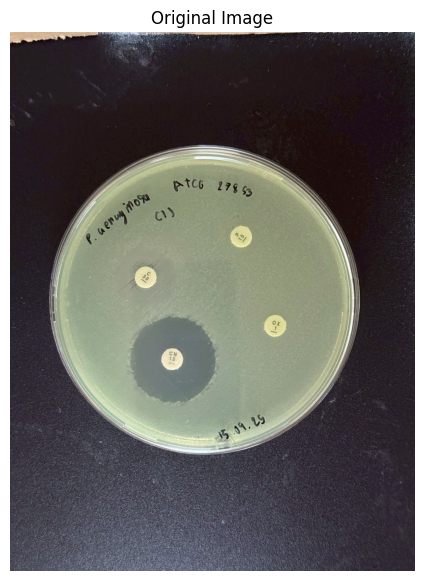

In [2]:
# --- Configuration ---
image_path = 'best/20250919_033735892_iOS.jpg' # Path to your example image
# ---------------------

try:
    img_original = cv2.imread(image_path)
    if img_original is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_gray, (9, 9), 2)
    
    print("Image loaded and pre-processed successfully.")
    display_images([img_original], ['Original Image'])

except FileNotFoundError as e:
    print(e)

### Cell 3: (Visualization) Sigmoid & Otsu Binarization

This cell is for visualization only. The high-contrast images are not used for detection in this workflow.

Sigmoid and Otsu images created for visualization.


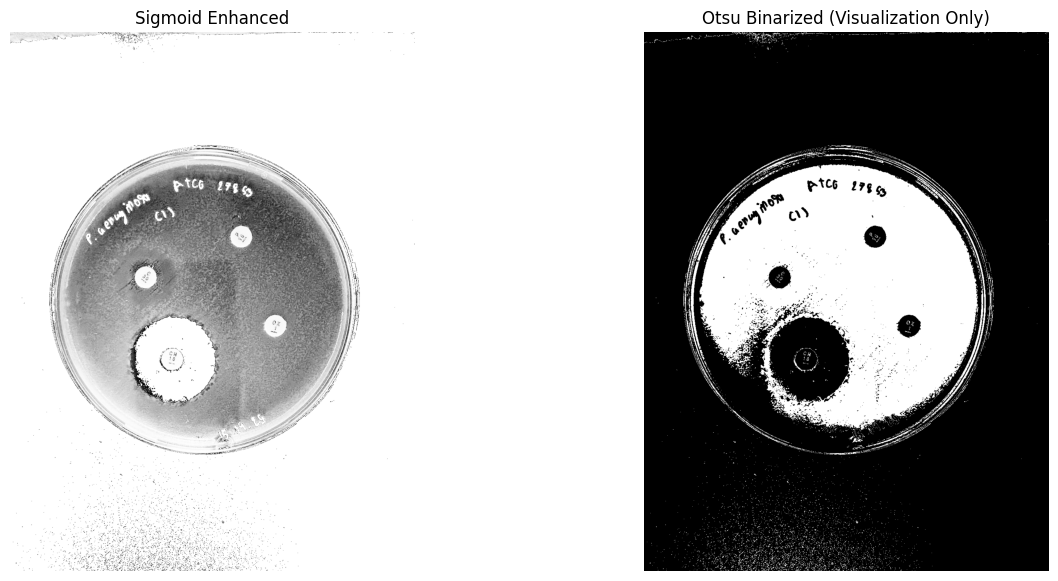

In [3]:
gain = 0.05 
img_normalized = (img_gray - 128) * gain
img_sigmoid = 1 / (1 + np.exp(-img_normalized))
img_sigmoid_enhanced = (img_sigmoid * 255).astype(np.uint8)
ret, img_otsu = cv2.threshold(
    img_sigmoid_enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

print("Sigmoid and Otsu images created for visualization.")
display_images(
    [img_sigmoid_enhanced, img_otsu],
    ['Sigmoid Enhanced', 'Otsu Binarized (Visualization Only)']
)

### Cell 4: Step 1 - Find SMALL Medicine Disks (Hough)

Finds the small medicine disks using Hough Transform and stores them in `disk_circles`.

Found 4 medicine disk(s).


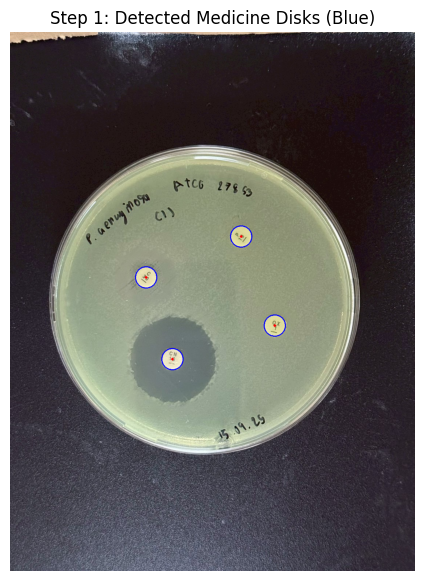

In [4]:
# --- Customize Disk Detection Parameters ---
disk_minDist = 40
disk_param2 = 30     
disk_minRadius = 15  
disk_maxRadius = 30  
# -----------------------------------------

disk_circles = cv2.HoughCircles(
    image=img_blurred,
    method=cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=disk_minDist,
    param1=50,
    param2=disk_param2,
    minRadius=disk_minRadius,
    maxRadius=disk_maxRadius
)

img_with_disks = img_original.copy()

if disk_circles is not None:
    disk_circles = np.uint16(np.around(disk_circles))
    print(f"Found {len(disk_circles[0])} medicine disk(s).")
    for i in disk_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(img_with_disks, center, 2, (0, 0, 255), 3)       # Red center
        cv2.circle(img_with_disks, center, radius, (255, 0, 0), 2)  # Blue outline
else:
    print("No medicine disks found. Try adjusting parameters.")

display_images([img_with_disks], ['Step 1: Detected Medicine Disks (Blue)'])

### Cell 5: Step 2 - Calibrate Pixel-to-MM Ratio

Uses the known 6mm diameter (3mm radius) of the medicine disks to create a conversion factor.

In [5]:
KNOWN_DISK_RADIUS_MM = 3.0  # (because diameter is 6mm)
mm_per_pixel = 0

if disk_circles is not None:
    # Calculate the average pixel radius from all found disks
    avg_pixel_radius = np.mean(disk_circles[0, :, 2])
    
    # Create the calibration factor
    mm_per_pixel = KNOWN_DISK_RADIUS_MM / avg_pixel_radius
    
    print(f"Calibration complete:")
    print(f"  Average disk radius in pixels: {avg_pixel_radius:.2f}")
    print(f"  Calculated mm per pixel: {mm_per_pixel:.4f}")
else:
    print("Cannot calibrate: No medicine disks were found in Cell 4.")

Calibration complete:
  Average disk radius in pixels: 29.00
  Calculated mm per pixel: 0.1034


### Cell 6: Step 3 - Find LARGE Inhibition Zones (YOLO)

Loads your pre-trained `best.pt` file and runs detection on the original image. The results are stored in `yolo_results`.

YOLO model 'doi_10_5061_dryad_5dv41nsfj__v20241013/runs/detect/train/weights/best.pt' loaded successfully.

0: 640x480 (no detections), 48.7ms
Speed: 26.9ms preprocess, 48.7ms inference, 32.9ms postprocess per image at shape (1, 3, 640, 480)
Found 0 potential zone(s).


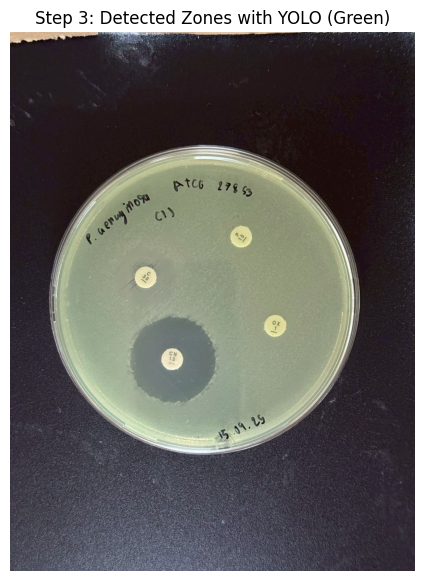

In [8]:
model_path = 'doi_10_5061_dryad_5dv41nsfj__v20241013/runs/detect/train/weights/best.pt' # Make sure this file is in the same folder!
yolo_results = []
img_with_zones = img_original.copy()

try:
    model = YOLO(model_path)
    print(f"YOLO model '{model_path}' loaded successfully.")
    
    # Run inference
    results = model(img_original)
    
    print(f"Found {len(results[0].boxes)} potential zone(s).")
    
    # Extract bounding boxes and draw them
    yolo_results = results[0].boxes.xywh.cpu().numpy() # Get (center_x, center_y, width, height)
    
    for box in yolo_results:
        center_x, center_y, width, height = box
        
        # Calculate an average radius from the YOLO box
        radius_pixels = int((width + height) / 4)
        center = (int(center_x), int(center_y))
        
        # Draw the circle
        cv2.circle(img_with_zones, center, radius_pixels, (0, 255, 0), 4) # Green outline
        
    display_images([img_with_zones], ['Step 3: Detected Zones with YOLO (Green)'])
    
except Exception as e:
    print(f"Error loading or running YOLO model: {e}")
    print("--- Make sure you have trained a model and placed 'best.pt' in the correct folder. ---")

### Cell 7: Step 4 - Final Combined Result & Measurement

This final cell combines all results and prints the final report, converting the zone's pixel radius into millimeters (mm).

--- Final Combined Report ---
Found 4 Medicine Disks (Blue)
No inhibition zones were detected by YOLO.


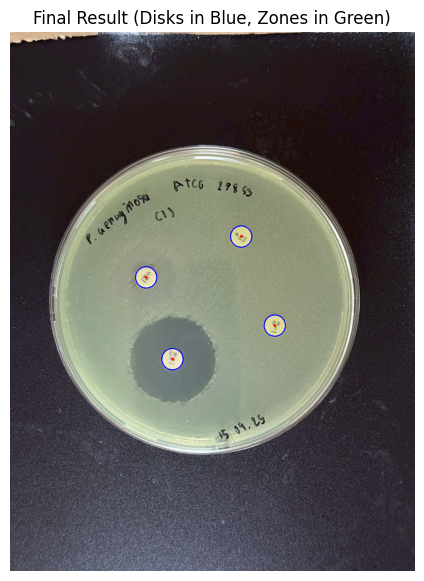

In [9]:
img_with_all_circles = img_original.copy()
print("--- Final Combined Report ---")

# Draw the medicine disks (from Cell 4) in BLUE
if disk_circles is not None:
    for i in disk_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(img_with_all_circles, center, 2, (0, 0, 255), 3)       # Red center
        cv2.circle(img_with_all_circles, center, radius, (255, 0, 0), 2)  # Blue outline
    print(f"Found {len(disk_circles[0])} Medicine Disks (Blue)")

# Draw the inhibition zones (from Cell 6) in GREEN and print measurements
if (len(yolo_results) > 0) and (mm_per_pixel > 0):
    print(f"Found {len(yolo_results)} Inhibition Zone(s) (Green)")
    for box in yolo_results:
        center_x, center_y, width, height = box
        radius_pixels = (width + height) / 4
        center = (int(center_x), int(center_y))
        
        # Convert pixel radius to mm
        radius_mm = radius_pixels * mm_per_pixel
        
        cv2.circle(img_with_all_circles, center, int(radius_pixels), (0, 255, 0), 4)
        
        # Print the final, calibrated measurement
        print(f"  - Zone at {center}:")
        print(f"     Radius: {radius_pixels:.1f} pixels")
        print(f"     Radius: {radius_mm:.2f} mm")
        print(f"     Diameter: {radius_mm * 2:.2f} mm")
        
elif len(yolo_results) == 0:
    print("No inhibition zones were detected by YOLO.")
else:
    print("Cannot measure zones: Calibration failed in Cell 5.")

# Display the final, combined image
display_images(
    [img_with_all_circles],
    ['Final Result (Disks in Blue, Zones in Green)']
)